In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.10.0+cu111'

In [ ]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),

    transforms.RandomCrop(32,padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [ ]:
Batch_Size = 128

Part 1: Load Data

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

In [ ]:
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


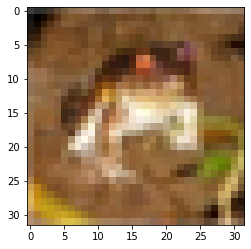

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

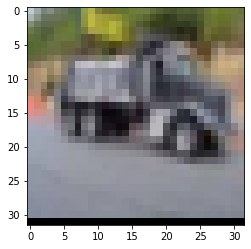

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)
imshow(im[0])

In [ ]:
im[0].shape

torch.Size([3, 32, 32])

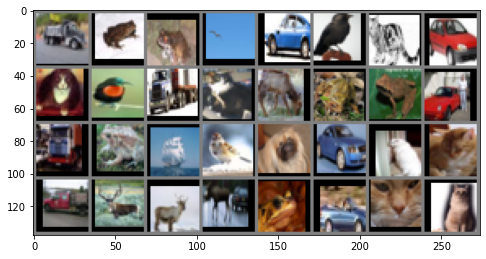

In [ ]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

Part 2: DenseNet

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [ ]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = torch.cat([out, x], 1)
        return out        

In [ ]:
test_net = Bottleneck(3, 5)
test_x = torch.zeros(1, 3, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 32 x 32
output shape: 8 x 32 x 32


In [ ]:
class Transition(nn.Module):
    """
    改变维数的Transition层 具体包括BN、ReLU、1×1卷积（Conv）、2×2平均池化操作
    先通过1x1的卷积层减少channels，再通过2x2的平均池化层缩小feature-map
    """
    # 1×1卷积的作用是降维，起到压缩模型的作用，而平均池化则是降低特征图的尺寸。
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
        
    def forward(self, x):
        out = self.features(x)
        return out

In [ ]:
test_net = Transition(3, 12)
test_x = torch.zeros(1, 3, 96, 96)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 12 x 48 x 48


In [ ]:
import math
class DenseNet(nn.Module):
    
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.layer1, num_channels = self._make_dense_layer(num_channels, num_blocks[0])
        self.layer2, num_channels = self._make_dense_layer(num_channels, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(num_channels, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(num_channels, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(num_channels, num_classes)
        
        self._initialize_weight()
        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [ ]:
def DenseNet121():
    return DenseNet([6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet([6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet([6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet([6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet([6,12,24,16], growth_rate=12)

net = DenseNet121().to(device)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          36,864
        Bottleneck-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          12,288
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 32,

In [ ]:
print(net)

DenseNet(
  (features): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): 

In [ ]:
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [ ]:
net = densenet_cifar().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)  
    torch.backends.cudnn.benchmark = True 

Part 3: Loss Function and Optimization

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # update lr
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

import time
epoch = 20

In [ ]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('exist!')
save_path = './model/Denset.pth'

Part 4: Train

In [ ]:
from utils import train2
from utils import plot_history
Acc, Loss, Lr = train2(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [  1/ 20]  Train Loss:1.458377  Train Acc:46.82% Test Loss:1.230144  Test Acc:56.85%  Learning Rate:0.100000	Time 01:25
Epoch [  2/ 20]  Train Loss:0.912826  Train Acc:67.40% Test Loss:0.787293  Test Acc:72.08%  Learning Rate:0.100000	Time 01:22
Epoch [  3/ 20]  Train Loss:0.695529  Train Acc:75.65% Test Loss:0.842282  Test Acc:71.67%  Learning Rate:0.100000	Time 01:23
Epoch [  4/ 20]  Train Loss:0.576693  Train Acc:80.01% Test Loss:0.648330  Test Acc:77.84%  Learning Rate:0.100000	Time 01:22
Epoch [  5/ 20]  Train Loss:0.505484  Train Acc:82.39% Test Loss:0.564463  Test Acc:80.67%  Learning Rate:0.100000	Time 01:22
Epoch [  6/ 20]  Train Loss:0.450149  Train Acc:84.18% Test Loss:0.510384  Test Acc:82.38%  Learning Rate:0.100000	Time 01:22
Epoch [  7/ 20]  Train Loss:0.421556  Train Acc:85.43% Test Loss:0.535721  Test Acc:81.62%  Learning Rate:0.100000	Time 01:22
Epoch [  8/ 20]  Train Loss:0.387670  Train Acc:86.62% Test Loss:0.503317  Test Acc:82.89%  Learning Rate:0.100000	Tim

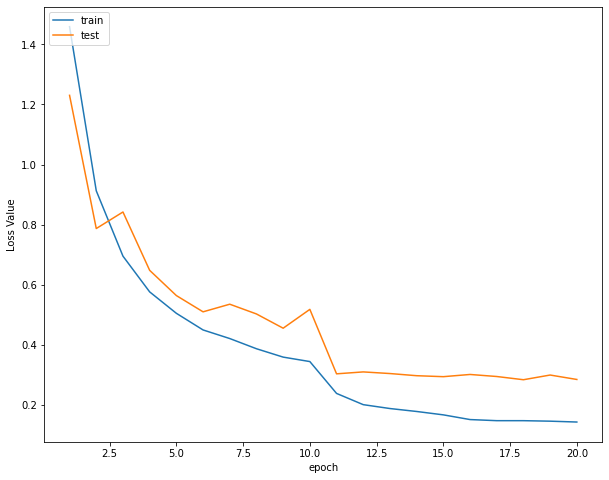

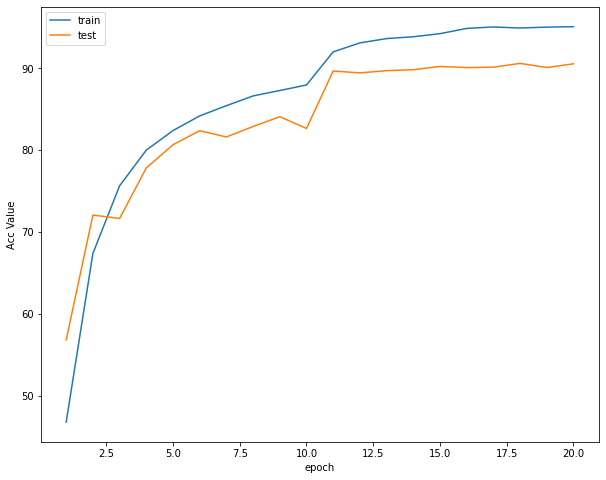

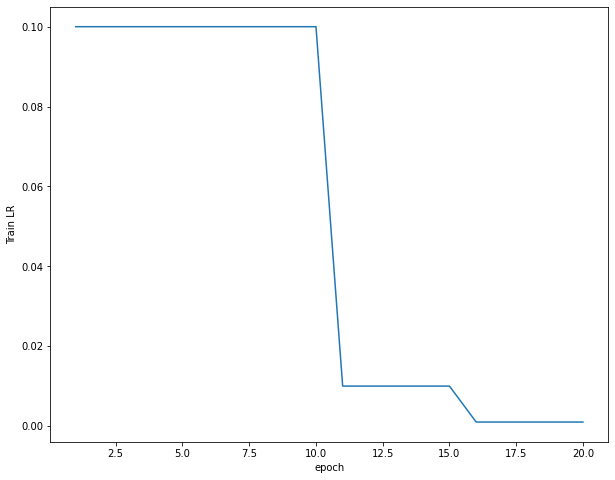

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

part 5: Test

In [ ]:
correct = 0   
total = 0     
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader:  
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval()  
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)  

        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          
        correct += (predicted == labels).sum() 

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 89.95 %
